![Practicum AI Logo image](https://github.com/PracticumAI/practicumai.github.io/blob/main/images/logo/PracticumAI_logo_250x50.png?raw=true) <img src='https://github.com/PracticumAI/deep_learning/blob/main/images/practicumai_deep_learning.png?raw=true' alt='Practicum AI: Deep Learning Foundations icon' align='right' width=50>
***

# Optimizing Computer Vision Models

!!! Flavor text goes here!!!

As before, the dataset was found on Kaggle. [Check out the dataset information](https://www.kaggle.com/datasets/amiteshpatra07/cattle-dataset-pig-sheep-cow-horse)

<img src="images/cattle_segmentation_cover.png" 
        alt="Image of a cow in a field." 
        width="1000" 
        height="200" 
        style="display: block; margin: 0 auto" />

!!! Insert Notes Here !!!



## 1.  Import the libraries we will use

In [1]:
# This notebook will be used for an Object Detection task that trains a model on the cattle_segmentation dataset using YOLOv8

# Importing the necessary libraries
import os
import sys
import json
import random
import pathlib
import requests
import zipfile
import time

import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision
from torchvision import transforms
from torchvision import datasets
from torchvision import models
from PIL import Image
import numpy as np
import pandas as pd
import torch
import yaml 
from ultralytics import YOLO
from ultralytics import settings

import helpers_02

import matplotlib.pyplot as plt
%matplotlib inline

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Training on {device}')

Training on cuda


## 2. Getting the data

Like Notebooks 1 and 2, we will have to find or download the dataset. This time the file is stored as a zip file, so we will need to extract it. 

You will also notice that instead of loading things to the **data** directory, the data is instead loaded to a new folder called **datasets**. This is a requirement of YOLOv8, which expects the data to be in a specific folder. The setting is *technically* possible to change, but is not something we want to hassle with right now.

In [3]:
# Similar to the helpers_01 functions in the prevoius notebooks,
# The helpers_02.manage_data() function will check for and, if needed,
# download the dataset.
data_path = helpers_02.manage_data(url="https://www.dropbox.com/scl/fi/6r8z3gmuy9plji8pd8nti/cattle_segmentation.zip?rlkey=uekp4dlikoobhapvw3vsjq0d4&st=6soxt9rk&dl=1", 
                                   filename="cattle_segmentation.zip",
                                  folder_name='cattle_segmentation')


Could not find data in the common locations. Do you know the path? (yes/no):  no
Do you want to download the data? (yes/no):  yes


Downloaded cattle_segmentation.zip successfully.
Data downloaded, unpacking
Extracted cattle_segmentation.zip to data successfully.
Data downloaded and unpacked. Now available at data/cattle_segmentation.


In [4]:
# Manage YOLO settings to set correct path to data folder
settings.update({"datasets_dir": data_path})

## 3. Explore the dataset

We will take a look at the dataset to see what it contains. We will also look at the annotations file, which contains the bounding box information for each image.

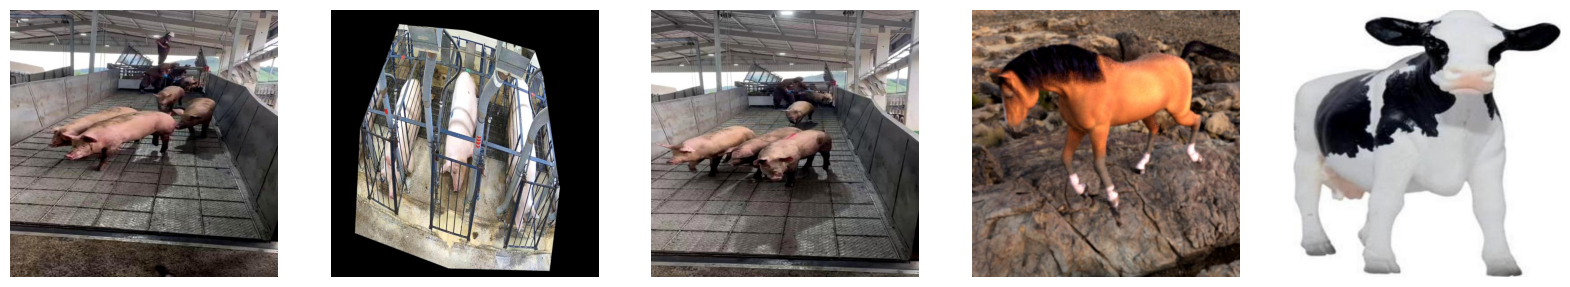

File: data/cattle_segmentation/train/labels/HolsteinFriesiancattle123_c_jpg.rf.743fd0e7c9653ab040a557ea89ca95ff.txt
  0 0.8994140625 0.458984375 0.919921875 0.4462890625 0.921875 0.4248046875 0.908203125 0.3955078125 0.90234375 0.3623046875 0.9326171875 0.353515625 0.939453125 0.3408203125 0.9296875 0.3212890625 0.892578125 0.2900390625 0.875 0.2548828125 0.8623046875 0.24609375 0.8427734375 0.244140625 0.7861328125 0.271484375 0.7236328125 0.267578125 0.7001953125 0.275390625 0.6357421875 0.26171875 0.5751953125 0.263671875 0.5400390625 0.251953125 0.4599609375 0.25390625 0.4462890625 0.248046875 0.3720703125 0.25 0.3017578125 0.244140625 0.2763671875 0.23046875 0.2509765625 0.2265625 0.1982421875 0.224609375 0.1611328125 0.232421875 0.1044921875 0.234375 0.0859375 0.2568359375 0.08203125 0.2861328125 0.083984375 0.3798828125 0.091796875 0.3994140625 0.0859375 0.4521484375 0.091796875 0.4580078125 0.09375 0.5126953125 0.087890625 0.5166015625 0.072265625 0.5751953125 0.08203125 0.7333

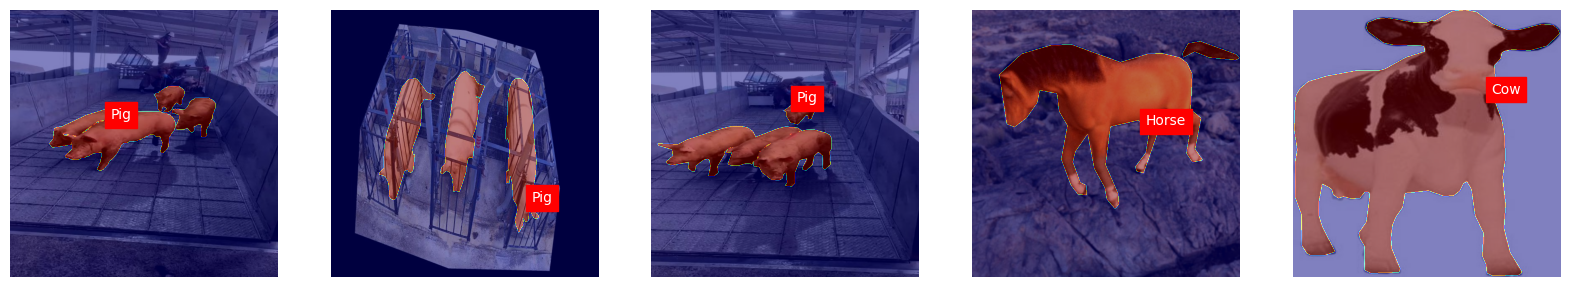

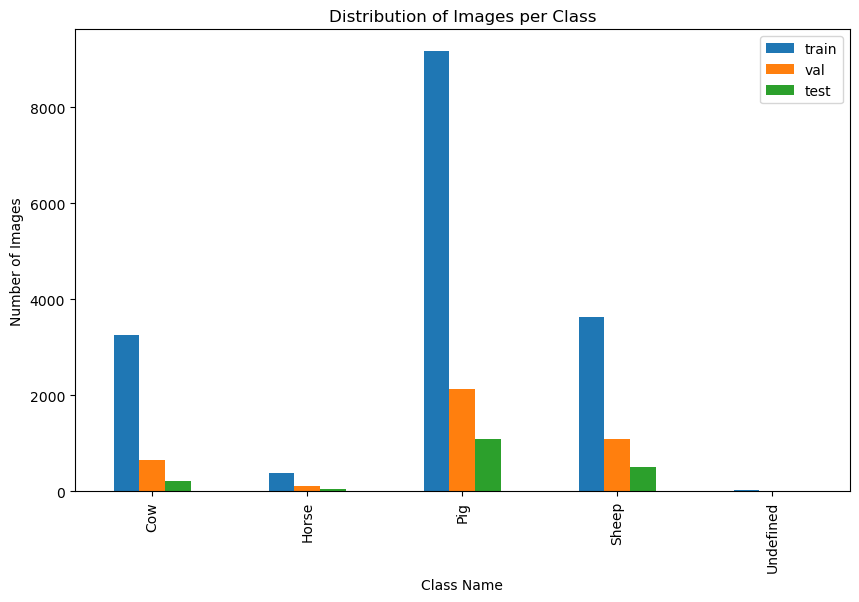

In [6]:

# Make a histogram of the number of images in each class
def explore_data(data_path, show_picture=True, show_annotation=True, show_segmentation=True, show_hist=True):

    # Define the class names
    class_names = ['Cow', 'Horse', 'Pig', 'Sheep', 'Undefined']

    # Initialize sample images list to store paths
    sample_images = []

    # Examine some sample images
    if show_picture:
        # Get valid image folders 
        image_folders = [f for f in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, f))] 

        for i in range(5):
            folder = random.choice(image_folders) 
            img_path = os.path.join(data_path, folder, 'images', random.choice(os.listdir(os.path.join(data_path, folder, 'images'))))
            sample_images.append(img_path)

        # Plot the sample images
        fig, axes = plt.subplots(1, 5, figsize=(20, 5))
        for i, img_path in enumerate(sample_images):
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].axis('off')
        plt.show()

    # Examine the first annotation file
    if show_annotation:
        annotation_files = []
        for folder in os.listdir(data_path):
            if os.path.isdir(os.path.join(data_path, folder)):
                annotation_folder = os.path.join(data_path, folder, 'labels')
                if os.path.exists(annotation_folder):
                    for file in os.listdir(annotation_folder):
                        annotation_files.append(os.path.join(annotation_folder, file))
        if annotation_files:
            annotation_file = annotation_files[0]  # Show only the first annotation file
            with open(annotation_file, 'r') as f:
                print(f"File: {annotation_file}")
                for i, line in enumerate(f):
                    if i > 4:
                        break
                    print(f"  {line.strip()}")

    # Plot the same sample images with their associated, labeled segmentation masks
    if show_segmentation and sample_images:
        # Find corresponding annotation files for the sample images
        sample_annotations = []
        for img_path in sample_images:
            folder = os.path.dirname(os.path.dirname(img_path))
            annotation_path = os.path.join(folder, 'labels', os.path.basename(img_path).replace('.jpg', '.txt'))
            sample_annotations.append((img_path, annotation_path))

        # Plot the sample images with segmentation masks
        fig, axes = plt.subplots(1, 5, figsize=(20, 5))
        for i, (img_path, annotation_path) in enumerate(sample_annotations):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            mask = np.zeros(img.shape[:2], dtype=np.uint8)
            with open(annotation_path, 'r') as f:
                for line in f:
                    class_id, *polygon = map(float, line.strip().split())
                    polygon = np.array(polygon).reshape(-1, 2) * [img.shape[1], img.shape[0]]
                    polygon = polygon.astype(np.int32)
                    cv2.fillPoly(mask, [polygon], 255)
            axes[i].imshow(img)
            axes[i].imshow(mask, alpha=0.5, cmap='jet')
            axes[i].axis('off')
            # Add class name above the segmentation mask
            if len(polygon) > 0:
                x, y = polygon[0]
                axes[i].text(x, y, class_names[int(class_id)], color='white', backgroundcolor='red')
        plt.show()

    # Make a histogram of the number of images in each class
    if show_hist:
        def get_class_counts(folder_path):  # Change from data_path to folder_path
            class_counts = {}
            labels_path = os.path.join(folder_path, 'labels')  # Add labels path
            for filename in os.listdir(labels_path):  # Update listdir
                with open(os.path.join(labels_path, filename), 'r') as f:
                    for line in f:
                        class_id = int(line.split(' ')[0])  # Assuming labels are in YOLO format
                        class_counts[class_id] = class_counts.get(class_id, 0) + 1
            return class_counts

        train_counts = get_class_counts(os.path.join(data_path, 'train'))  # Add os.path.join
        val_counts = get_class_counts(os.path.join(data_path, 'valid'))
        test_counts = get_class_counts(os.path.join(data_path, 'test'))
        num_classes = len(class_names)

        data_counts = {
            'train': pd.Series(train_counts),
            'val': pd.Series(val_counts),
            'test': pd.Series(test_counts)
        }
        df = pd.DataFrame(data_counts)

        df.plot.bar(figsize=(10, 6))
        plt.xlabel('Class Name')
        plt.xticks(np.arange(num_classes), class_names)
        plt.ylabel('Number of Images')
        plt.title('Distribution of Images per Class')
        plt.legend()
        plt.show()

explore_data(data_path, show_picture=True, show_annotation=True, show_segmentation=True, show_hist=True)


As with the fruit detection notebook, there are some issues with this cattle dataset!
- Not all the animals in some of the images are annotated.
- The annotation file names are the same as the image names, but with a .txt extension.
- The annotations file contains the class ID of the animal (0 corresponds to 'Cow', etc.), and the segmentation coordinates. 
- The segmenation coordinates are the pixel locations for the vertices of the segmenting polygons.
- The segmentation coordinates are normalized, meaning that they are scaled to be between 0 and 1. This is a common practice in object detection tasks.
- The dataset is very imbalanced, with a lot more pigs than other animals, and comparitively almost no horses.

## 4. Create the YAML file
YAML stands for "YAML Ain't Markup Language" and is a human-readable data serialization format. A YAML file is used to define the dataset configuration for training a YOLOv8 model. YAML configuration files are popular in deep learning because they are easier for humans to read and write, with the goal being to increase transparency and reproducibility.

In [7]:
# Create a YAML file for the YOLOv8 model configuration

def create_yaml(data_path, class_names, yaml_file='cattle_segmentation_data.yaml'):
    # Creates a YOLOv8 data.yaml file.
    
    yaml_dict = {
        # 'path': data_path,  # Path to your dataset
        'train': data_path + '/train/images',  # Relative path to training images
        'val': data_path + '/valid/images',    # Relative path to validation images
        'test': data_path + '/test/images',    # Relative path to testing images

        'num_classes': len(class_names),   # Number of classes
        'names': class_names      # List of class names
    }

    with open(yaml_file, 'w') as outfile:
        yaml.dump(yaml_dict, outfile, default_flow_style=False)

    print(f'YAML file created: {yaml_file}')

data_path = 'cattle_segmentation/cattle_segmentation_clean.yolov8'
class_names = ['Cow', 'Horse', 'Pig', 'Sheep', 'Undefined']

create_yaml(data_path, class_names) 

YAML file created: cattle_segmentation_data.yaml


## 5. Create and fit the model

We will create a YOLOv8 model and fit it to the data. YOLOv8 has a lot of hyperparameters that can be tuned, but we will use the default values for now. For more information on the it's hyperparameters, [check out it's documentation](https://docs.ultralytics.com/modes/train/).

Another neat feature of YOLOv8 is that by default it provides several evaluation metrics, such as the loss, precision, recall, and F1 score. This is very useful for monitoring the model's performance during training.

In [8]:
# Make the YOLOv8 model
model = YOLO('yolov8n.yaml')
results = model.train(data='cattle_segmentation_data.yaml', imgsz=640, epochs=10)

New https://pypi.org/project/ultralytics/8.2.18 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.2 🚀 Python-3.12.3 torch-2.3.0 CUDA:0 (NVIDIA A100-SXM4-80GB, 81038MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=cattle_segmentation_data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train8, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=Fal

RuntimeError: Dataset 'cattle_segmentation_data.yaml' error ❌ 
Dataset 'cattle_segmentation_data.yaml' images not found ⚠️, missing path '/blue/practicum-ai/share/data/fruits_detection/cattle_segmentation/cattle_segmentation_clean.yolov8/valid/images'
Note dataset download directory is '/blue/practicum-ai/share/data/fruits_detection'. You can update this in '/home/magitz/.config/Ultralytics/settings.yaml'

## 6. Evaluate the results

Let's look at those evaluation metrics we mentioned above. YOLOv8 creates a **runs** folder that stores each training run. We'll pull them up here and examine what they mean.

In [ ]:
# Plot the evaluation results

# Find the latest training run
training = sorted(os.listdir('runs/detect/.'))
latest_training = training[-1]
print(f'Latest training run: {latest_training}')

# Plot the .png files in the latest training run
for file in os.listdir(f'runs/detect/{latest_training}'):
    if file.endswith('.png'):
        # Exclude the normalized confusion matrix since it's redundant
        if 'normalized' in file:
            continue
        img = Image.open(f'runs/detect/{latest_training}/{file}')
        plt.imshow(img)
        plt.axis('off')
        plt.show()

## Breaking down the graphs
If your stats are a little rusty like Kevin's, you might need a bit of refresher to make sense of the graphs above. Expand the section below for a rundown on the terms used above.

<details>
    
<summary><h2>Click to Expand for Stats Terms!</h2></summary>

<p>

##### What is Precision?
Precision is the ratio of correctly predicted positive observations to the total predicted positives. An example in our fruit object detection task would be the ratio of correctly predicted apples to the total predicted apples. Higher precision values are better, as they indicate that the model is making more accurate predictions.

##### What is Recall?
Recall is the ratio of correctly predicted positive observations to the all observations in actual class. An example in our fruit object detection task would be the ratio of correctly predicted apples to the total actual apples. Higher recall values are better, as they indicate that the model is making more accurate predictions.

##### What is Confidence?
Confidence is the probability that a model assigns to a prediction. In our fruit object detection task, the confidence is the probability that a model assigns to a fruit being an apple, orange, or any other fruit. Higher confidence values are better, as they indicate that the model is more certain about its predictions.

##### What is a confusion matrix?
A confusion matrix is a table that is often used to describe the performance of a classification model on a set of test data for which the true values are known. It allows the visualization of the performance of an algorithm. The confusion matrix shows the ways in which your classification model is confused when it makes predictions. It gives you insight not only into the errors being made by your classifier but more importantly the types of errors that are being made.

##### What is the F1 Confidence Curve?
The F1 Confidence Curve is a plot of the F1 score against the confidence threshold. The F1 score is the harmonic mean of precision and recall, and it is a measure of a model's accuracy. The confidence threshold is the minimum confidence level that a model must have in order to make a prediction. The F1 Confidence Curve is used to determine the optimal confidence threshold for a model. The curve shows how the F1 score changes as the confidence threshold is varied. The goal is to find the confidence threshold that maximizes the F1 score. The highest point on the curve tells you the optimal confidence threshold where the model strikes the best balance between precision and recall. In our fruit object detection task, the F1 Confidence Curve would show how the F1 score changes as the confidence threshold is varied for each fruit class. Higher F1 scores are better, as they indicate that the model is making more accurate predictions.
    
##### What is mAP50?
mAP50 stands for "mean Average Precision at 50% confidence". It is a common metric used in object detection tasks to evaluate the performance of a model. The mAP50 is the average of the precision values at different recall levels, where the recall is calculated at a confidence threshold of 50%. A higher mAP50 value indicates better performance.
    
##### What is mAP50-95?
mAP50-95 is the mean average precision (mAP) over the range of intersection over union (IoU) thresholds from 0.5 to 0.95. IoU is a measure of the overlap between two bounding boxes. It is calculated as the area of the intersection of the two bounding boxes divided by the area of their union. An IoU of 0 means that the two bounding boxes do not overlap at all, while an IoU of 1 means that the two bounding boxes are identical. The mAP50-95 metric is a more comprehensive metric than the mAP50 metric, which only considers the IoU threshold of 0.5. The mAP50-95 metric provides a more complete picture of the model's performance across a range of IoU thresholds.

</p>
</details>

In addition to those graphs, we can look at the predictions themselves. 

In [ ]:
# Plot the labels and predictions from the last training run

# Load the images
img1 = Image.open(f'runs/detect/{latest_training}/val_batch0_labels.jpg')
img2 = Image.open(f'runs/detect/{latest_training}/val_batch0_pred.jpg')

# Plot the images
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(img1)
axes[0].axis('off')
axes[0].set_title('Ground Truth')
axes[1].imshow(img2)
axes[1].axis('off')
axes[1].set_title('Predictions')
plt.show()


From the prediction images, you'll probably notice this model loves its citrus. That's no surprise given the histogram we looked at at the beginning of this notebook. What could we do to improve this?

## 7. Inference
How does the model fair on some test images? After you run the cell below:
1. Find your own image of fruit.
2. Upload it to this folder.
3. Add or edit the code below to run on the new image rather than images in the test folder.


In [ ]:
# Run the model on a few test images
data_path = r"datasets/cattle_segmentation"

# Get ten random test images
test_images = []
for folder in os.listdir(os.path.join(data_path, 'test', 'images')):
    img_path = os.path.join(data_path, 'test', 'images', folder)
    test_images.append(img_path)
test_images = random.sample(test_images, 10)

# Plot the test images
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
for i, img_path in enumerate(test_images):
    img = Image.open(img_path)
    axes[i // 5, i % 5].imshow(img)
    axes[i // 5, i % 5].axis('off')
plt.show()

# Run the model on the test images
infer_results = model.predict(test_images)

for img_path, result in zip(test_images, infer_results):
    img = Image.open(img_path)
    img = img.resize((640, 640))

    # Create the plot for this image
    plt.imshow(img)
    plt.axis('off')

    # Access bounding boxes and class information
    boxes = result.boxes
    class_ids = boxes.cls.cpu().numpy()  # Class IDs are on the CPU
    confidences = boxes.conf.cpu().numpy()  # Confidences are on the CPU

    for box, class_id, conf in zip(boxes.xyxy, class_ids, confidences):  
        # boxes.xyxy are in [xmin, ymin, xmax, ymax] format
        x1, y1, x2, y2 = box.cpu()  # Move coordinates to CPU
        w, h = x2 - x1, y2 - y1
        rect = plt.Rectangle((x1, y1), w, h, fill=False, color='red', linewidth=2)
        plt.gca().add_patch(rect)
        plt.text(x1, y1, result.names[int(class_id)], color='red')  

    # Display the plot
    plt.show()

## 8. Explore hyperparameters

Now that you have a good baseline, consider how you might deal with this model's issues.
- How would you address issues in the dataset?
- How would you optimize training?

A good first place to start would be YOLOv8's documentation so you can understand what hyperparameters you have access to and how changing them will affect training. Make some adjustments and see how high you can get your fruits object detection F1 score!

## Bonus Exercises

- You might have noticed the *yolov8n.pt* file that is added to the folder when you load YOLO. That is the pre-trained model using the [COCO dataset](https://cocodataset.org/#home). The YOLOv8 documentation linked above provides instructions for transer learning and fine-tuning with the pre-trained model. Give it a shot!

- If you're feeling very bold and want the full Object Detection Experience, find an image labeler and build your own dataset! If you use proprietary data, be sure that the software you use to label meets your institution's guidelines for data sharing. If you go this route, you will almost certainly want to use the fine-tuning option mentioned above, otherwise you're going to be spending quite a long time labeling...